# Week 7 Homework

This week, we'll be talking about adversarial examples. Basically, we fool the neural network into thinking that an image which is abnormal is totally healthy--super scary stuff!

In [1]:
import numpy as np
import os, scipy.ndimage, scipy.misc
import matplotlib.pyplot as plt
from skimage import util 

import keras
import keras.backend as K
from keras.models import load_model
from keras.objectives import binary_crossentropy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load the Model

First, we load a pre-trained model on this task. Run the code below to load it. This is the model we are going to break.

In [2]:
model = load_model('resources/trained_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 72, 72, 32)        128       
__________

## Pick a Test Case

We now pick an image that we are going to play with. This image is an abnormal sample from the test set--in other words, we pick an image from the test set which shows an unhealthy lession on the skin of the patient. Notice that the output the model predicts is quite close to 1, so it is very confident that this is unhealthy. We will make the network believe this is healthy!

/usr/local/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


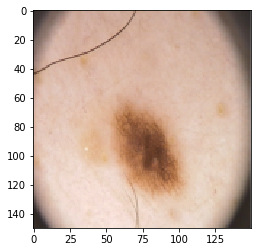

Prediction using this image:  0.8752293


In [5]:
img_path = 'resources/addi/test/abnormal/IMD024.png'
img = scipy.ndimage.imread(img_path).astype(float)
img = scipy.misc.imresize(img, (150, 150, 3))[np.newaxis, :, :, :]/255.0

plt.imshow(np.squeeze(img))
plt.show()

print("Prediction using this image: ", model.predict(img)[0, 0])

## Untargeted Noise

Before we dive into how adversarial examples work, try this out: just intialize some random noise and add it to our above image. Then, see how the model does. Mess around with the scaling/shifting factor of the noise to try to get the score below 0.5 (making the model think it is healthy). This is called an untargeted attack--we don't know what output the model will give this noisy input.

In [ ]:
scale, shift = .2, 0
noise = np.random.rand(1, 150, 150, 3) * scale + shift

noisy_img = np.clip(img + noise, 0, 1)
plt.imshow(np.squeeze(noisy_img))
plt.show()

print("Prediction using this image: ", model.predict(noisy_img)[0, 0])

## Targeted Noise

Now for the interesting stuff: we will change the image until we fool the model. How does this work? It's quite simple: we compute the gradient of the normal class score with respect to the input image. This tells us how much to change the input image to maximize the normal class score--i.e. how do we change the unhealthy image to make it look healthy. That's it!

Notice how, as we execute this code to do that, the score decreases. Mess with the pertubation amount to try to get the model output below a 0.5 on this input. This means that the model now thinks that the unhealthy image is healthy!

In [ ]:
pertubation_amount = 0.1

fooling_img = img.copy()
for _ in range(10):
    # We create a function that gets the gradients of BCE Loss with respect to the input image
    y_true = K.placeholder((1, 1))
    loss = K.mean(binary_crossentropy(y_true, model.output))
    get_grads = K.function([model.input, y_true], K.gradients(loss, model.input))

    # We pass in the input image and the label we want the model to output (0)
    grad = get_grads([fooling_img, [[0]]])[0]
    fooling_img = np.clip(fooling_img - pertubation_amount*grad, 0, 1)
    plt.imshow(fooling_img[0])
    plt.show()
    
    # If our model thinks the image is normal, stop right here
    pred = model.predict(fooling_img)[0, 0]
    print(pred)
    if pred <= 0.5:
        break

## Visualize the "Fooling" Image

Let's see how this adversarial example looks!

In [ ]:
plt.imshow(np.squeeze(fooling_img))
plt.show()
pred = model.predict(fooling_img)[0, 0]
print("Prediction using this image: ", pred)

Wow, this looks exactly like the input image! However, our model thinks that this is healthy when it is clearly not. In just a couple of steps, you were able to take an unhealthy image and make it look healthy to the network. That is super scary! This is something to keep in mind as you design your high-stake ML algorithms.

If you want to know more about adversarial examples and how we can protect against them, check out [this paper on the topic](https://arxiv.org/pdf/1712.07107.pdf). For a more casual read, check out [this neat blog post](https://www.anishathalye.com/2017/07/25/synthesizing-adversarial-examples/) on the topic.